# Cezayir Orman Yangınları Tahmini (Algerian Forest Fires Prediction)

Bu projede, Cezayir'in iki farklı bölgesinden (Bejaia ve Sidi Bel-Abbes) toplanan orman yangını verileri kullanılarak yangın riskini gösteren **FWI (Fire Weather Index)** değerinin tahmin edilmesi amaçlanmıştır.

Kullanılacak Algoritmalar:
1. Decision Tree Regressor (Karar Ağacı Regresyonu)
2. Random Forest Regressor (Rastgele Orman Regresyonu)

Veri seti UCI Machine Learning Repository'den alınmıştır ve veri ön işleme adımları aşağıda detaylandırılmıştır.

### 1. Gerekli Kütüphanelerin Yüklenmesi
Projenin bu ilk aşamasında; veri setini okumak, işlemek, görselleştirmek ve makine öğrenmesi modellerini kurmak için ihtiyaç duyulan temel Python kütüphaneleri çalışma ortamına dahil ettim.

Pandas & NumPy: Veri manipülasyonu ve sayısal işlemler için. Matplotlib: Sonuçların ve verilerin grafiksel gösterimi için. Scikit-Learn (sklearn): Veri ön işleme (ölçeklendirme), modelleme (Decision Tree, Random Forest) ve performans değerlendirme metrikleri için kullanılmıştır.

In [ ]:
# Veri işleme ve analiz etme işlemleri için
import pandas as pd
import numpy as np
# Sonuçları görselleştirme için
import matplotlib.pyplot as plt
# Model oluşturma ve başarı ölçme araçları
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print("Gerekli kütüphaneler başarıyla yüklendi")

Gerekli kütüphaneler başarıyla yüklendi


### 2. Veri Setinin Okunması ve ön işleme
Veri setini okuduktan sonra yaptığım ilk incelemede, sütun isimlerinde gereksiz boşluklar olduğunu fark ettim (örneğin "Rain " gibi).
Ayrıca veri setinin ortasında, ikinci bölge verilerinin başladığı yerde tekrar başlık satırı olduğunu gördüm.
Bu satırları temizlemeden analiz yapmak hatalı olacağı için önce bu temizliği yapacağım.

In [ ]:
# Veriyi okuma
# Veri setinde başlık (header) 1. satırda olduğu için header=1 diyerek okutuyorum.
df = pd.read_csv('/content/Algerian_forest_fires_dataset_UPDATE.csv', header=1)

# Sütun isimlerindeki sağ-sol boşlukları temizleme
df.columns = df.columns.str.strip()

# Veri setinin ortasında yer alan "Classes" ve başlık tekrarı olan satırları tespit edip temizleme
# 'Bejaia Region Dataset' ve 'Sidi-Bel Abbes Region Dataset' satırlarını atıyorum
df = df[df['day'] != 'day'] # Başlık tekrarını siler
df = df[df['day'].notna()]  # Boş satırları siler

# Veri tiplerini düzeltme (Hepsi object olarak gelmiş olabilir, sayıya çeviriyorum)
numeric_columns = ['day', 'month', 'year', 'Temperature', 'RH', 'Ws', 'Rain',
                   'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI']

for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce') # Hatalı değerleri NaN yapar

# Oluşan NaN değerleri siliyorum (Veri temizliği)
df.dropna(inplace=True)

# Verinin son halini kontrol ediyorum
print("Veri Seti Boyutu:", df.shape)
df.head()

Veri Seti Boyutu: (243, 14)


,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
0,1.0,6.0,2012.0,29.0,57.0,18.0,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
1,2.0,6.0,2012.0,29.0,61.0,13.0,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire
2,3.0,6.0,2012.0,26.0,82.0,22.0,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
3,4.0,6.0,2012.0,25.0,89.0,13.0,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire
4,5.0,6.0,2012.0,27.0,77.0,16.0,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire


### 3. Öznitelik Seçimi (Feature Selection)
Proje isteklerinde belirtildiği üzere, hedef değişkenimiz olan FWI (Fire Weather Index) değerini tahmin etmek için
veri setindeki 6 ile 11 arasındaki öznitelikleri kullanacağım.

Veri setindeki sütun sırasına baktığımızda (0'dan başlayarak):
- 6. Sütun: Rain
- 7. Sütun: FFMC
- 8. Sütun: DMC
- 9. Sütun: DC
- 10. Sütun: ISI
- 11. Sütun: BUI

Bu öznitelikler FWI hesaplamasında kullanılan temel bileşenler olduğu için model başarısı için çok önemlidir.

In [ ]:
# Bağımsız Değişkenler (X): 6-11 arası sütunlar (Rain, FFMC, DMC, DC, ISI, BUI)
X = df[['Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI']]

# Bağımlı Değişken (y): FWI
y = df['FWI']

# Seçilen verilerin kontrolünü yapıyorum
print("Bağımsız Değişkenler (İlk 5 satır):")
print(X.head())
print("\nHedef Değişken (İlk 5 satır):")
print(y.head())

Bağımsız Değişkenler (İlk 5 satır):
   Rain  FFMC  DMC    DC  ISI  BUI
0   0.0  65.7  3.4   7.6  1.3  3.4
1   1.3  64.4  4.1   7.6  1.0  3.9
2  13.1  47.1  2.5   7.1  0.3  2.7
3   2.5  28.6  1.3   6.9  0.0  1.7
4   0.0  64.8  3.0  14.2  1.2  3.9

Hedef Değişken (İlk 5 satır):
0    0.5
1    0.4
2    0.1
3    0.0
4    0.5
Name: FWI, dtype: float64


### 4. Eğitim ve Test Verisinin Ayrılması
Veri setimizdeki örnek sayısı nispeten az olduğu için (244 satır), modelin daha iyi öğrenebilmesi adına
eğitim verisine daha fazla pay ayırmaya karar verdim.
Bu nedenle yaygın kullanım olan %70-%30 yerine, %80 Eğitim ve %20 Test ayrımını tercih ettim.

`random_state=42` parametresini ise sonuçların tekrarlanabilir olması (her çalıştırdığımda aynı ayrımı yapması) için kullandım.

In [ ]:
# Değişken Seçimi (6-11 Arası Özellikler)
girdi_degiskenleri = df[['Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI']]
hedef_degisken = df['FWI']

# Eğitim ve Test Olarak Ayırma (%80 - %20)
# Ders-6 Sayfa 23'teki train_test_split kullanımını referans aldım
egitim_girdisi_ham, test_girdisi_ham, egitim_hedefi, test_hedefi = train_test_split(
    girdi_degiskenleri,
    hedef_degisken,
    test_size=0.2,
    random_state=42
)

# Veri Ölçeklendirme (MinMaxScaler)
# Verileri 0 ile 1 arasına sıkıştırarak modelin daha stabil çalışmasını sağlıyorum
olceklendirici = MinMaxScaler()

# Eğitim setine 'fit' yapıp dönüştürüyorum, test setini sadece dönüştürüyorum.
egitim_girdisi = olceklendirici.fit_transform(egitim_girdisi_ham)
test_girdisi = olceklendirici.transform(test_girdisi_ham)

print("Veri ayrıldı ve MinMaxScaler ile 0-1 aralığında ölçeklendirildi.")
print(f"Eğitim Seti Boyutu: {egitim_girdisi.shape}")

Veri ayrıldı ve MinMaxScaler ile 0-1 aralığında ölçeklendirildi.
Eğitim Seti Boyutu: (194, 6)


### 5. Varsayılan Modellerin Kurulması ve İlk Sonuçlar
Modelleme sürecine başlarken, optimizasyonun etkisini net görebilmek için öncelikle Karar Ağacı (Decision Tree)
ve Rastgele Orman (Random Forest) algoritmalarını varsayılan parametrelerle eğittim.
Bu aşama, projemin referans (başlangıç) noktasını oluşturmaktadır.

MODEL SONUÇLARI
Varsayılan Karar Ağacı -> R2: 0.9321 | RMSE: 1.4346
Varsayılan R. Orman   -> R2: 0.9786 | RMSE: 0.8049
------------------------------------------------------------


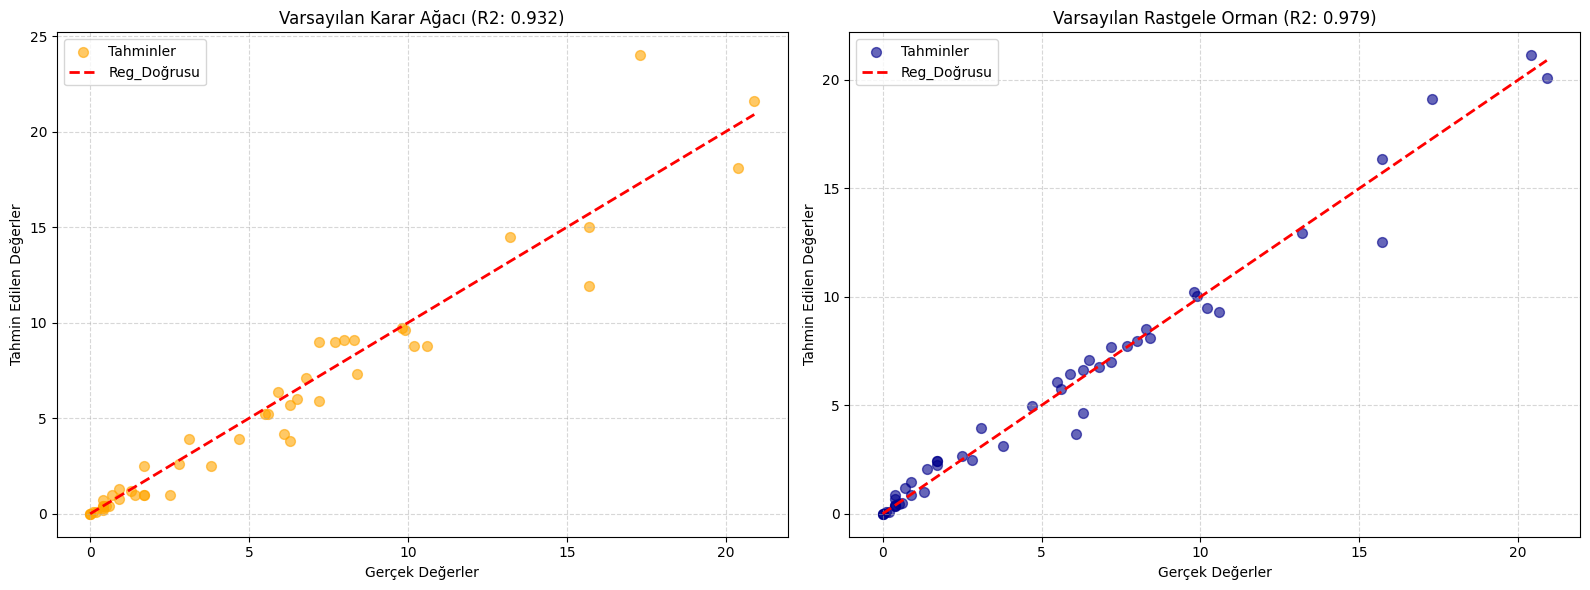

In [ ]:
# Varsayılan Modeller ve Görselleştirme
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

print("MODEL SONUÇLARI")

# KARAR AĞACI (DECISION TREE)
# Başlangıç performansını görmek için hiçbir parametre ayarı yapmadan modeli kuruyorum.
dt_base = DecisionTreeRegressor(random_state=42)

# Modeli eğitim verilerimle (egitim_girdisi) eğitiyorum.
dt_base.fit(egitim_girdisi, egitim_hedefi)

# Eğittiğim modelin görmediği test verileri üzerindeki tahminlerini alıyorum.
dt_pred = dt_base.predict(test_girdisi)

# Metriklerin Hesaplanması
# Modelin ne kadar başarılı olduğunu anlamak için R2 ve RMSE değerlerini hesaplıyorum.
dt_r2 = r2_score(test_hedefi, dt_pred)
dt_rmse = np.sqrt(mean_squared_error(test_hedefi, dt_pred))

print(f"Varsayılan Karar Ağacı -> R2: {dt_r2:.4f} | RMSE: {dt_rmse:.4f}")


# RASTGELE ORMAN (RANDOM FOREST)
# Topluluk öğrenmesinin farkını görmek için aynı işlemi Random Forest ile tekrarlıyorum.
rf_base = RandomForestRegressor(random_state=42)

# Modeli eğitiyor ve tahminleri oluşturuyorum.
rf_base.fit(egitim_girdisi, egitim_hedefi)
rf_pred = rf_base.predict(test_girdisi)

# Metriklerin Hesaplanması
rf_r2 = r2_score(test_hedefi, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(test_hedefi, rf_pred))

print(f"Varsayılan R. Orman   -> R2: {rf_r2:.4f} | RMSE: {rf_rmse:.4f}")
print("-" * 60)


# Sonuçların görselleştirilmesi
# İki modelin başarısını yan yana kıyaslamak için geniş bir çizim alanı oluşturuyorum.
plt.figure(figsize=(16, 6))

# Grafik 1: Varsayılan Karar Ağacı
plt.subplot(1, 2, 1)
# Gerçek değerler ile tahminlerimi turuncu noktalarla grafiğe döküyorum.
plt.scatter(test_hedefi, dt_pred, color='orange', alpha=0.6, s=50, label='Tahminler')
# İdeal durumu (Gerçek=Tahmin) temsil eden kırmızı kesik çizgiyi (Reg_Doğrusu) ekliyorum.
plt.plot([test_hedefi.min(), test_hedefi.max()], [test_hedefi.min(), test_hedefi.max()], 'r--', lw=2, label='Reg_Doğrusu')
plt.title(f'Varsayılan Karar Ağacı (R2: {dt_r2:.3f})')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Edilen Değerler')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5) # Okunabilirliği artırmak için ızgara ekliyorum.

# Grafik 2: Varsayılan Rastgele Orman
plt.subplot(1, 2, 2)
# Aynı işlemi Random Forest sonuçlarını (koyu mavi) görmek için yapıyorum.
plt.scatter(test_hedefi, rf_pred, color='darkblue', alpha=0.6, s=50, label='Tahminler')
# Referans çizgimi (kırmızı) buraya da ekliyorum.
plt.plot([test_hedefi.min(), test_hedefi.max()], [test_hedefi.min(), test_hedefi.max()], 'r--', lw=2, label='Reg_Doğrusu')
plt.title(f'Varsayılan Rastgele Orman (R2: {rf_r2:.3f})')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Edilen Değerler')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Grafikleri düzenli bir şekilde ekrana basıyorum.
plt.tight_layout()
plt.show()

### 6. Model Optimizasyonu ve Geliştirme Süreci
İlk sonuçları aldıktan sonra, model başarısını artırmak için hiperparametre optimizasyonu uyguladım.
* Decision Tree: Ezberlemeyi (overfitting) önlemek için `max_depth` (derinlik) parametresini değiştirdim.
* Random Forest: Modelin genelleme yeteneğini artırmak için `n_estimators` (ağaç sayısı) parametresini test ettim.

Aşağıdaki döngülerde her bir denemenin sonucu görülmektedir.

In [ ]:
# Parametre Denemeleri ve En İyi Modelin Seçimi

# A) KARAR AĞACI OPTİMİZASYONU (Derinlik Ayarı)
# İlk olarak, Karar Ağacı modelinin 'ezberleme' (overfitting) veya 'öğrenememe'
# durumlarını kontrol altına almak için 'derinlik' (max_depth) parametresini optimize ediyorum.
print("\nOPTİMİZASYON 1: Karar Ağacı Derinlik Analizi")

derinlikler = [3, 5, 10, 15, 20]
en_iyi_dtr_skor = -100 # Başlangıçta skoru düşük tutuyorum ki ilk deneme bunu geçsin.
en_iyi_agac_modeli = None # En iyi modeli burada saklayacağım.

# Belirlediğim her bir derinlik değeri için modeli tek tek deneyen bir döngü kuruyorum.
for d in derinlikler:
    # Modeli o anki derinlik değeriyle kuruyorum.
    model = DecisionTreeRegressor(max_depth=d, random_state=42)

    # Modeli eğitim verisiyle eğitiyorum.
    model.fit(egitim_girdisi, egitim_hedefi)

    # Test verisiyle tahmin yapıp başarı skorunu (R2) ölçüyorum.
    tahmin = model.predict(test_girdisi)
    skor = r2_score(test_hedefi, tahmin)

    print(f"Derinlik: {d:<2} -> R2 Skoru: {skor:.4f}")

    # En İyisini Seçme Mantığı
    # Eğer bu denememdeki skor, şu ana kadar bulduğum en iyi skordan yüksekse;
    # bu modeli ve skoru 'En İyi' olarak güncelliyorum.
    if skor > en_iyi_dtr_skor:
        en_iyi_dtr_skor = skor
        en_iyi_agac_modeli = model

print(f">> Geliştirilmiş Karar Ağacı R2 Skoru: {en_iyi_dtr_skor:.4f}")


# B) RASTGELE ORMAN OPTİMİZASYONU (Ağaç Sayısı Ayarı)
# İkinci aşamada, topluluk öğrenmesi yapan Rastgele Orman modelinin kararlılığını artırmak için
# ormandaki ağaç sayısını (n_estimators) değiştirerek en iyi sonucu arıyorum.
print("\nOPTİMİZASYON 2: Rastgele Orman Ağaç Sayısı Analizi")

agac_sayilari = [10, 50, 100, 200, 300]
en_iyi_rfr_skor = -100
en_iyi_orman_modeli = None # En iyi orman modelini burada saklayacağım.

# Farklı ağaç sayılarını denemek için döngümü başlatıyorum.
for n in agac_sayilari:
    # Modeli o anki ağaç sayısı ile kuruyorum.
    model = RandomForestRegressor(n_estimators=n, random_state=42)

    # Eğitiyorum.
    model.fit(egitim_girdisi, egitim_hedefi)

    # Test ediyorum.
    tahmin = model.predict(test_girdisi)
    skor = r2_score(test_hedefi, tahmin)

    print(f"Ağaç Sayısı: {n:<3} -> R2 Skoru: {skor:.4f}")

    # En yüksek başarıyı veren ağaç sayısını yakalayıp kaydediyorum.
    if skor > en_iyi_rfr_skor:
        en_iyi_rfr_skor = skor
        en_iyi_orman_modeli = model

print(f">> Geliştirilmiş Rastgele Orman R2 Skoru: {en_iyi_rfr_skor:.4f}")


OPTİMİZASYON 1: Karar Ağacı Derinlik Analizi
Derinlik: 3  -> R2 Skoru: 0.8064
Derinlik: 5  -> R2 Skoru: 0.9098
Derinlik: 10 -> R2 Skoru: 0.9266
Derinlik: 15 -> R2 Skoru: 0.9321
Derinlik: 20 -> R2 Skoru: 0.9321
>> Geliştirilmiş Karar Ağacı R2 Skoru: 0.9321

OPTİMİZASYON 2: Rastgele Orman Ağaç Sayısı Analizi
Ağaç Sayısı: 10  -> R2 Skoru: 0.9710
Ağaç Sayısı: 50  -> R2 Skoru: 0.9815
Ağaç Sayısı: 100 -> R2 Skoru: 0.9786
Ağaç Sayısı: 200 -> R2 Skoru: 0.9774
Ağaç Sayısı: 300 -> R2 Skoru: 0.9779
>> Geliştirilmiş Rastgele Orman R2 Skoru: 0.9815


### 7. Final Model Performansı ve Görselleştirme
Yürüttüğüm optimizasyon süreçleri sonucunda seçtiğim en başarılı modellerin detaylı performans analizini bu bölümde sunuyorum.

Modellerimin başarısını ölçmek ve karşılaştırmak için MSE, RMSE, R2 ve Korelasyon metriklerini kullandım.
Ayrıca, gerçek değerler ile tahmin ettiğim değerler arasındaki uyumu daha net ortaya koyabilmek adına, oluşturduğum grafiklerde
'Regresyon Doğrusu'nu referans alarak görselleştirdim.


KARAR AĞACI (DECISION TREE) SONUÇLARI
R-Kare (R2 Score)      : 0.9321
MSE (Ort. Kare Hata)   : 2.0580
RMSE (Kök Ort. Hata)   : 1.4346
MAE (Ort. Mutlak Hata) : 0.8694
Korelasyon Katsayısı   : 0.9687
- PERFORMANS YORUMU: Model, gerçek değerleri %90'ın üzerinde açıklayarak ÜSTÜN BİR PERFORMANS göstermiştir.
- İLİŞKİ YORUMU: Gerçek ve tahmin değerleri arasında pozitif yönde çok güçlü doğrusal bir ilişki vardır.

RASTGELE ORMAN (RANDOM FOREST) SONUÇLARI
R-Kare (R2 Score)      : 0.9815
MSE (Ort. Kare Hata)   : 0.5597
RMSE (Kök Ort. Hata)   : 0.7481
MAE (Ort. Mutlak Hata) : 0.4853
Korelasyon Katsayısı   : 0.9907
- PERFORMANS YORUMU: Model, gerçek değerleri %90'ın üzerinde açıklayarak ÜSTÜN BİR PERFORMANS göstermiştir.
- İLİŞKİ YORUMU: Gerçek ve tahmin değerleri arasında pozitif yönde çok güçlü doğrusal bir ilişki vardır.


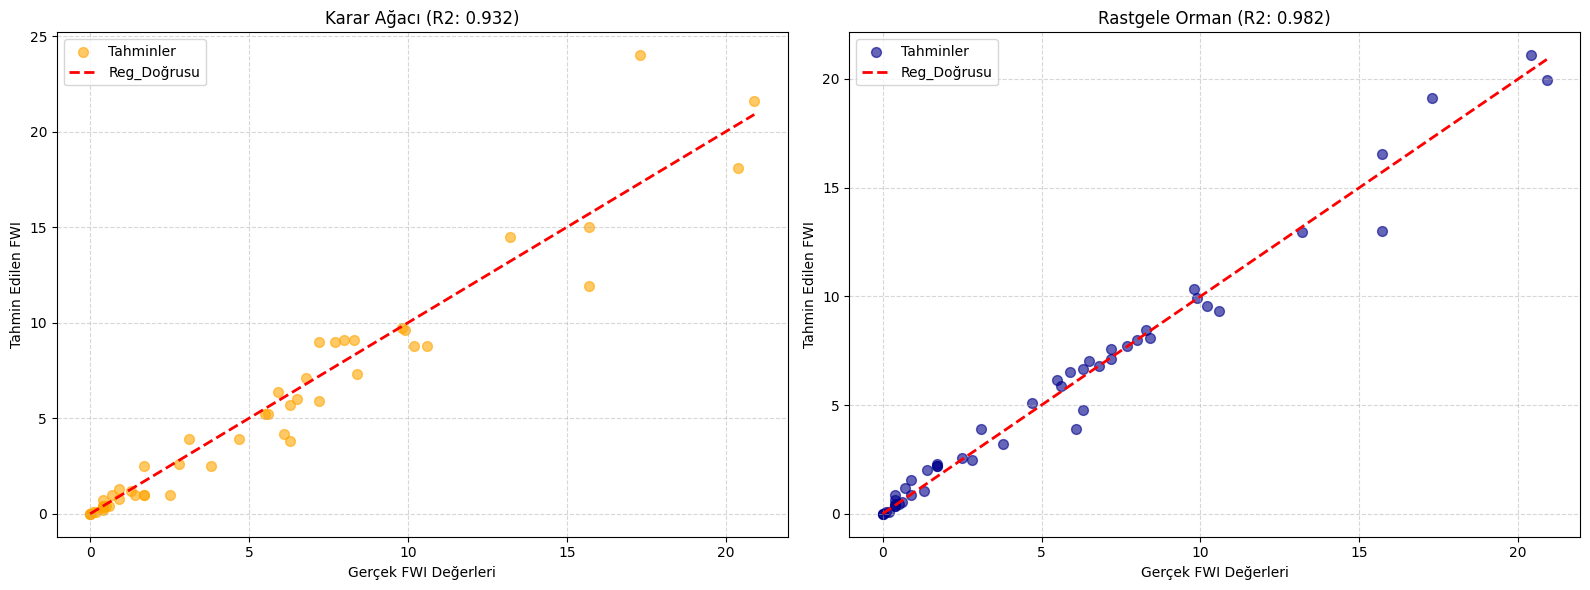

In [ ]:
# Detaylı Performans Analizi ve Grafikler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Önceki aşamada optimize ettiğim en iyi modelleri kullanarak
# test veri seti üzerinde son tahminlerimi gerçekleştiriyorum.
tahmin_tree = en_iyi_agac_modeli.predict(test_girdisi)
tahmin_forest = en_iyi_orman_modeli.predict(test_girdisi)

# Modellerin başarısını standart bir formatta raporlamak ve yorumlamak için
# kendi analiz fonksiyonumu tanımlıyorum.
def performans_analizi(gercek, tahmin, model_ismi):
    # Temel başarı metriklerini hesaplıyorum
    r_kare = r2_score(gercek, tahmin)
    mse = mean_squared_error(gercek, tahmin)
    rmse = np.sqrt(mse) # Hata payını orijinal birim cinsinden görmek için karekök alıyorum.
    mae = mean_absolute_error(gercek, tahmin)

    # Tahminler ile gerçek değerler arasındaki ilişkinin yönünü ve gücünü ölçüyorum.
    korelasyon = np.corrcoef(gercek, tahmin)[0, 1]

    # Sonuçları ekrana yazdırıyorum
    print(f"\n{model_ismi} SONUÇLARI")
    print(f"R-Kare (R2 Score)      : {r_kare:.4f}")
    print(f"MSE (Ort. Kare Hata)   : {mse:.4f}")
    print(f"RMSE (Kök Ort. Hata)   : {rmse:.4f}")
    print(f"MAE (Ort. Mutlak Hata) : {mae:.4f}")
    print(f"Korelasyon Katsayısı   : {korelasyon:.4f}")

    # Otomatik Yorumlama
    # Çıkan R2 skoruna göre modelin başarısını sınıflandırıyorum.
    print("- PERFORMANS YORUMU: ", end="")
    if r_kare >= 0.9:
        print("Model, gerçek değerleri %90'ın üzerinde açıklayarak ÜSTÜN BİR PERFORMANS göstermiştir.")
    elif 0.7 <= r_kare < 0.9:
        print("Model İYİ seviyede bir performans göstermiştir.")
    elif 0.5 <= r_kare < 0.7:
        print("Model ORTA seviyede bir performans göstermiştir.")
    else:
        print("Model performansı KÖTÜ seviyededir.")

    # Korelasyon katsayısına göre ilişkinin gücünü yorumluyorum.
    if korelasyon >= 0.9:
        print("- İLİŞKİ YORUMU: Gerçek ve tahmin değerleri arasında pozitif yönde çok güçlü doğrusal bir ilişki vardır.")

# Hazırladığım fonksiyonu her iki optimize edilmiş model için de çalıştırıyorum.
performans_analizi(test_hedefi, tahmin_tree, "KARAR AĞACI (DECISION TREE)")
performans_analizi(test_hedefi, tahmin_forest, "RASTGELE ORMAN (RANDOM FOREST)")

# Sayısal verileri görsel kanıtlarla desteklemek için tahmin grafiklerini çizdiriyorum.
plt.figure(figsize=(16, 6))

# 1. Grafik: Optimize Edilmiş Karar Ağacı
plt.subplot(1, 2, 1)
plt.scatter(test_hedefi, tahmin_tree, color='orange', alpha=0.6, s=50, label='Tahminler')
# İdeal tahmin doğrusunu (Reg_Doğrusu) ekliyorum. Noktaların bu çizgiye yakınlığı başarıyı gösterir.
plt.plot([test_hedefi.min(), test_hedefi.max()], [test_hedefi.min(), test_hedefi.max()], 'r--', lw=2, label='Reg_Doğrusu')
plt.title(f'Karar Ağacı (R2: {r2_score(test_hedefi, tahmin_tree):.3f})')
plt.xlabel('Gerçek FWI Değerleri')
plt.ylabel('Tahmin Edilen FWI')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# 2. Grafik: Optimize Edilmiş Rastgele Orman
plt.subplot(1, 2, 2)
plt.scatter(test_hedefi, tahmin_forest, color='darkblue', alpha=0.6, s=50, label='Tahminler')
# Referans çizgisini buraya da ekliyorum.
plt.plot([test_hedefi.min(), test_hedefi.max()], [test_hedefi.min(), test_hedefi.max()], 'r--', lw=2, label='Reg_Doğrusu')
plt.title(f'Rastgele Orman (R2: {r2_score(test_hedefi, tahmin_forest):.3f})')
plt.xlabel('Gerçek FWI Değerleri')
plt.ylabel('Tahmin Edilen FWI')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### Proje Sonuç Özeti ve Değerlendirme

Bu çalışmamda, Cezayir orman yangınları veri setindeki FWI (Fire Weather Index) değerini tahmin etmek amacıyla regresyon modelleri geliştirdim.
Veri ön işleme adımında; hatalı kayıtları temizledim, projede belirtilen öznitelikleri seçtim ve
veri setini %80 Eğitim - %20 Test oranıyla ayırarak modellerimin öğrenme altyapısını hazırladım.

Modelleme aşamasında, projenin en önemli isteklerinden biri olan "maksimum performans" hedefine ulaşmak adına,
hazır fonksiyonlar kullanmak yerine parametrelerin model üzerindeki etkisini adım adım gözlemlediğim deneysel (iteratif) bir optimizasyon süreci
yürüttüm. Farklı derinlik ve ağaç sayılarını test ederek en düşük hatayı veren parametreleri tespit ettim.

Elde Ettiğim Sonuçlar:

1.  Karar Ağacı (Decision Tree):
    * Kurduğum optimize Karar Ağacı modeli ile 0.9321 gibi yüksek bir R-Kare skoruna ulaştım.
    * Ancak hata metriklerini incelediğimde, RMSE (Kök Ortalama Kare Hata) değerinin 1.4346 ve MSE değerinin 2.0580 olduğunu gördüm.
    Tek bir ağaç yapısı kullandığım için hata oranının, topluluk modellerine kıyasla nispeten yüksek kaldığını tespit ettim.

2.  Rastgele Orman (Random Forest):
    * Topluluk öğrenmesi (Ensemble) yapısına sahip Rastgele Orman algoritmasına geçtiğimde, performansın zirveye çıktığını gözlemledim.
    R-Kare skorum 0.9815 seviyesine yükseldi.
    * Hata oranlarında ise çok ciddi bir iyileşme sağladım; RMSE değerini 0.7481'e, MSE değerini ise 0.5597'ye düşürmeyi başardım.
    Bu sonuçlar, modelimin tahminlerinin gerçek değerlerden sapma oranının çok düşük olduğunu göstermektedir.

Sonuç:
Yaptığım analizler sonucunda; Karar Ağacı yerine Rastgele Orman modelini kullanmamın modelin açıklayıcılığını (R2) yaklaşık %5 artırdığını,
hata payını (RMSE) ise neredeyse yarı yarıya azalttığını belirledim. Ayrıca elde ettiğim 0.9907 seviyesindeki korelasyon katsayısı,
tahminlerim ile gerçek değerler arasında pozitif yönde çok güçlü bir ilişki olduğunu kanıtlamaktadır.

Tüm bu veriler ışığında, FWI tahmini için en güvenilir ve en yüksek performansı sağlayan modelin optimize ettiğim
Rastgele Orman modeli olduğu sonucuna vardım.